You can find this ipynb also in github, on\
https://github.com/Evanslearn/1st-Semester-AI-2023-2024-/tree/main/MachineLearning/Final%20Project

# Import Libraries

In [1]:
# Here we import the libraries we will use
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf

def install_agent_libraries():
  !pip install swig
  !pip install gymnasium[box2d]
  !pip install ray[rllib]
  !pip install renderlab
#install_agent_libraries()

In [2]:
# Check if GPU is enabled
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
import imageio.v3 as iio
import glob
from skimage import color
from skimage.exposure import rescale_intensity
from skimage.transform import resize

# 1. Express the moves (rock, scissors, paper) into (0, 1, 2) respectively

In [4]:
label_names = ['rock', 'scissors', 'paper']

In [5]:
# This function labels a specific action with the appropriate number
def return_image_labels(action, labels_length):

  if action == 'rock':
    label = 0
  if action == 'scissors':
    label = 1
  if action == 'paper':
    label = 2

  # We create our array, which will be either all 0s, 1s, or 2s
  labels = np.zeros(labels_length) + label

  return labels

In [6]:
# This function returns all images from a folder, in grayscale
def return_all_images_grayscale(folder):
  images = []

  # This is used to load the images
  for im_path in glob.glob(f"{folder}/*.png"):
    im = iio.imread(im_path)[:,:,:3] # We keep only the first 3 coordinates, so we throw away

    # Resize image, to reduce dimensionality (from (200, 300) to -> (20, 30) )
    im = resize(im, (dim1, dim2))

    # Convert images to grayscale, to reduce dimensionality
    im = color.rgb2gray(im)
    im = rescale_intensity(im, out_range=(0, 255))

    images.append(im)

  images = np.array(images)

  # If the folder is not called 'rock', 'paper', 'scissors, but 'rock_xxx', 'paper_xxx', 'scissors_xxx', handle it
  if folder not in ['rock','paper','scissors']:
    strings = folder.split('_')

    for string in strings:
      if string == 'rock':
        folder = 'rock'
      if string == 'paper':
        folder = 'paper'
      if string == 'scissors':
        folder = 'scissors'

  images_labels = return_image_labels(folder, len(images))

  return [images, images_labels]

In [7]:
dim1 = 20; dim2 = 30;

In [8]:
[images_rock, images_rock_labels] = return_all_images_grayscale('rock')
[images_scissors, images_scissors_labels] = return_all_images_grayscale('scissors')
[images_paper, images_paper_labels] = return_all_images_grayscale('paper')

# 2. Split the dataset into train-test: You can for each class select a ratio as test set (e.g. 20% of rock, 20% of scissors and 20% of paper) and use these to test your model/agent.

In [9]:
random_state = 0 # This is set to 0 (this way, we get the same results every time)
test_ratio = 0.2

In [10]:
# split into train and test sets
x_train_rock, x_test_rock, y_train_rock, y_test_rock = train_test_split(images_rock, images_rock_labels, test_size = test_ratio, random_state = random_state)
x_train_scissors, x_test_scissors, y_train_scissors, y_test_scissors = train_test_split(images_scissors, images_scissors_labels, test_size = test_ratio, random_state = random_state)
x_train_paper, x_test_paper, y_train_paper, y_test_paper = train_test_split(images_paper, images_paper_labels, test_size = test_ratio, random_state = random_state)

In [11]:
print(f'For sanity check, dimensions of \nall Rock images {images_rock.shape}, \ntrain set rock images {x_train_rock.shape}, \ntest set rock images: {x_test_rock.shape} ')

For sanity check, dimensions of 
all Rock images (726, 20, 30), 
train set rock images (580, 20, 30), 
test set rock images: (146, 20, 30) 


In [12]:
# Create the x_train, x_test, y_train, y_test, by contatenating the respective arrays
x_train = np.concatenate((x_train_rock, x_train_scissors, x_train_paper))
x_test = np.concatenate((x_test_rock, x_test_scissors, x_test_paper))

y_train = np.concatenate((y_train_rock, y_train_scissors, y_train_paper))
y_test = np.concatenate((y_test_rock, y_test_scissors, y_test_paper))

In [13]:
print(f'For sanity check, dimensions of \ntrain Rock images {x_train_rock.shape}, \ntrain set scissors images {x_train_scissors.shape}, \ntest set paper images: {x_train_paper.shape} ')
print(f'\nDimensions of x_train: {x_train.shape}')

For sanity check, dimensions of 
train Rock images (580, 20, 30), 
train set scissors images (600, 20, 30), 
test set paper images: (569, 20, 30) 

Dimensions of x_train: (1749, 20, 30)


In [14]:
# We use the reshape method to do the flattening.
# We simply designate that the number of rows should remain the same, and -1 as second argument takes care of the other dimensions
x_train_flatten = x_train.reshape(x_train.shape[0], -1)
x_test_flatten = x_test.reshape(x_test.shape[0], -1)
print(f'x_train.shape = {x_train.shape}. x_train_flatten.shape = {x_train_flatten.shape}')
print(f'x_test.shape = {x_test.shape}. x_train_flatten.shape = {x_test_flatten.shape}')

x_train.shape = (1749, 20, 30). x_train_flatten.shape = (1749, 600)
x_test.shape = (439, 20, 30). x_train_flatten.shape = (439, 600)


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # Define our scaler

x_train_flatten_norm = scaler.fit_transform(x_train_flatten)
x_test_flatten_norm = scaler.transform(x_test_flatten)

In [16]:
# Convert y_train, y_test to one-hot encodings
num_classes = 3 # classes (0, 1, 2) -> (rock, scissors, paper)

y_train_tf = tf.one_hot(y_train, depth=num_classes)
y_test_tf = tf.one_hot(y_test, depth=num_classes)
y_train_tf.shape, y_test_tf.shape

(TensorShape([1749, 3]), TensorShape([439, 3]))

In [17]:
# Reshape our arrays, to make them appropriate for CNN in tensorflow
# We set dim1 and dim2, when resizing the images during data reading
x_train_cnn = np.reshape(x_train_flatten_norm, (x_train_flatten_norm.shape[0], dim1,dim2,1))
x_test_cnn = np.reshape(x_test_flatten_norm, (x_test_flatten_norm.shape[0], dim1,dim2,1))

cnn = tf.keras.Sequential(name='my-cnn')
cnn.add(tf.keras.layers.Input((dim1,dim2,1), name='input_layer'))

In [18]:
# Parameters for our CNN
num_conv_layers = 2
num_filters = 64
kernel_size = (5,5)
strides = (1,1)
mlp_num_hidden_layers = 2
mlp_units_per_layer = 128
activation = 'relu'
dropout_rate = 0.4

In [19]:
# Add our parameters to our CNN
for i in range(num_conv_layers):
  cnn.add(
      tf.keras.layers.Conv2D(
          filters=num_filters,
          kernel_size=kernel_size,
          strides=strides,
          activation=activation,
          name=f'conv_layer{i+1}'
      )
  )
  cnn.add(tf.keras.layers.Dropout(rate=dropout_rate , name=f'dropout_{i+1}'))
  cnn.add(tf.keras.layers.MaxPooling2D(name=f'maxpool_{i+1}'))

In [20]:
# Flattening
cnn.add(tf.keras.layers.Flatten())

In [21]:
# MLP
for i in range(mlp_num_hidden_layers):
  cnn.add(tf.keras.layers.Dense(units=mlp_units_per_layer, name=f'hidden_layer_{i+1}'))
cnn.add(tf.keras.layers.Dense(units=num_classes, activation='softmax', name='output_layer'))
cnn.summary()

Model: "my-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 16, 26, 64)        1664      
                                                                 
 dropout_1 (Dropout)         (None, 16, 26, 64)        0         
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 13, 64)         0         
                                                                 
 conv_layer2 (Conv2D)        (None, 4, 9, 64)          102464    
                                                                 
 dropout_2 (Dropout)         (None, 4, 9, 64)          0         
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 2, 4, 64)          0         
                                                                 
 flatten (Flatten)           (None, 512)               0    

In [22]:
print(x_train_cnn.shape, y_train_tf.shape)

(1749, 20, 30, 1) (1749, 3)


In [23]:
# Train our CNN
learning_rate = 0.001
loss = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 16 # Initially I had tried 32
epochs = 50


start_time = time.perf_counter() # Get current time at start

cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=metrics)
history = cnn.fit(x_train_cnn, y_train_tf, batch_size=batch_size, epochs=epochs)#, validation_data=(x_test_cnn, y_test_tf))

end_time = time.perf_counter() # Get current time at end
cnn_neural_time = end_time - start_time # Substract the time at start and time at end, to find the total run time
print(f"Training Time: {cnn_neural_time:.4f}")

Epoch 1/50
110/110 [==============================] - 5s 34ms/step - loss: 0.8157 - accuracy: 0.6118
Epoch 2/50
110/110 [==============================] - 3s 28ms/step - loss: 0.2595 - accuracy: 0.9005
Epoch 3/50
110/110 [==============================] - 3s 26ms/step - loss: 0.1862 - accuracy: 0.9383
Epoch 4/50
110/110 [==============================] - 3s 27ms/step - loss: 0.1318 - accuracy: 0.9543
Epoch 5/50
110/110 [==============================] - 4s 34ms/step - loss: 0.0957 - accuracy: 0.9674
Epoch 6/50
110/110 [==============================] - 3s 26ms/step - loss: 0.0796 - accuracy: 0.9748
Epoch 7/50
110/110 [==============================] - 3s 25ms/step - loss: 0.0602 - accuracy: 0.9766
Epoch 8/50
110/110 [==============================] - 3s 26ms/step - loss: 0.0764 - accuracy: 0.9703
Epoch 9/50
110/110 [==============================] - 4s 33ms/step - loss: 0.0525 - accuracy: 0.9834
Epoch 10/50
110/110 [==============================] - 3s 27ms/step - loss: 0.0472 - accura

In [24]:
# From the training, we have the statistics stored in object history:
print(history.history.keys())

losses = history.history['loss']
accuracies = history.history['accuracy']
#val_losses = history.history['val_loss']
#val_accuracies = history.history['val_accuracy']

dict_keys(['loss', 'accuracy'])


<ipython-input-25-f3f8114bb9b4>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
<ipython-input-25-f3f8114bb9b4>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


Text(0.5, 1.0, 'Accuracy vs epoch')

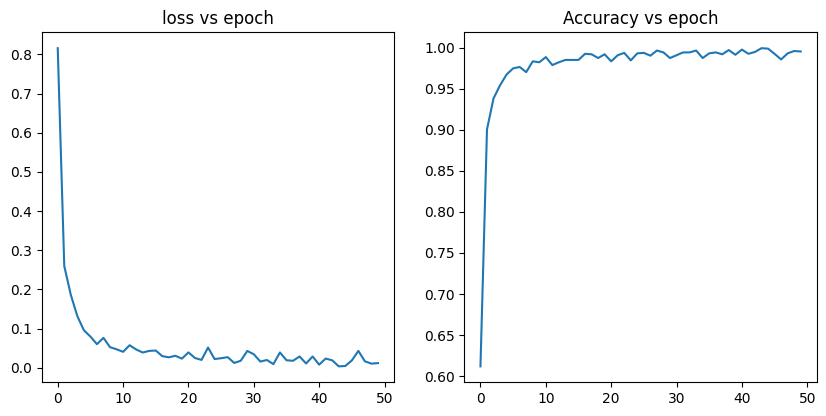

In [25]:
# Plot the results of our training, for each epoch
f, axs = plt.subplots(1, 2, figsize=(10, 10))

plt.subplot(2,2,1)
plt.plot(losses)
plt.title('loss vs epoch')

plt.subplot(2,2,2)
plt.plot(accuracies)
plt.title('Accuracy vs epoch')

#plt.subplot(2,2,3)
#plt.plot(val_losses)
#plt.title('loss(val) vs epoch')

#plt.subplot(2,2,4)
#plt.plot(val_accuracies)
#plt.title('Accuracy(val) vs epoch')

In [26]:
cnn_test_loss, cnn_test_acc = cnn.evaluate(x_test_cnn, y_test_tf, verbose=2)
print('')
print(f'Our CNN has achieved a test accuracy of {cnn_test_acc*100:.2f}%')

14/14 - 0s - loss: 0.1084 - accuracy: 0.9704 - 328ms/epoch - 23ms/step

Our CNN has achieved a test accuracy of 97.04%


## **Our CNN has achieved a test accuracy of accuracy: 97.52%**

# 3. Select Image: Select a radom image frm the 2100 (which corresponds to move 0, or 1, or 2)

In [27]:
import random

In [28]:
# I will select a random image from the test set
# since the method returns [a, b], I have set [1, length], and then deduct 1
random_integer = random.randint(1, len(x_test)) - 1

random_image = x_test[random_integer]
random_image_label = y_test[random_integer]
random_image_label_string = label_names[int(random_image_label)]

# 4. Preprocess Image: Process the image:

*  a. wih probability $p_1$ apply Vertical flip

In [29]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [30]:
def flip_vertically(image, p1 = 0.5):

  random_float = random.random()

  if random_float >= p1:
    image = np.flip(image, axis = 0) # We flip vertically

  return image

random_image = flip_vertically(random_image)

*  b. with probability $p_2$ apply Horizontal flip



In [31]:
def flip_horizontally(image, p2 = 0.5):

  random_float = random.random()

  if random_float >= p2:
    image = np.flip(image, axis = 1) # We flip horizontally

  return image

random_image = flip_horizontally(random_image)

*  c. Add noise with $\mu = 0$, $\sigma = 255\cdot 0.05$. If you normalize the image, adjust standard deviation accordingly.

In [32]:
def add_noise(image, mu = 0, sigma = 255 * 0.05):

  # if we have normalized, then normalize sigma as well
  if sigma == 255 * 0.05:
    if np.max(image) <= 1:
      sigma = sigma/255
  image = image + np.random.normal(mu, sigma, image.shape) # Add the gaussian noise
  return image

random_image = add_noise(random_image)

*  d. You can apply any other method Image Processing you want, so that you can make the game harder (if you want).

In [33]:
from scipy.ndimage import rotate

In [34]:
# I will also add a 45 degrees rotation, with probability 0.5
def rotate_angle(image, p3 = 0.5, angle = 45):

  random_float = random.random()

  if random_float >= p3:
    image = rotate(image, angle=45, reshape=False)
  return image

random_image = rotate_angle(random_image)

# 5. Apply: Send the image to your agent

In [35]:
# COnvert the image to tf tensor
img_array = tf.keras.utils.img_to_array(random_image)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# Calculate predictions
predictions = cnn.predict(img_array)
score = tf.nn.softmax(predictions[0])
predicted_enemy_action = label_names[np.argmax(predictions[0])]

print(
    "This image most likely belongs to {} = {} with a {:.2f} percent confidence."
    .format(np.argmax(predictions[0]), predicted_enemy_action, 100 * np.max(score))
)

1/1 [==============================] - 0s 108ms/step
This image most likely belongs to 0 = rock with a 57.61 percent confidence.


# 6. The agent reads the image and selects the optimal action

In [36]:
# This function selects the winning action, given the enemy action
def select_optimal_action(enemy_action):

  if enemy_action == 'rock':
    optimal_action = 'paper'
  if enemy_action == 'scissors':
    optimal_action = 'rock'
  if enemy_action == 'paper':
    optimal_action = 'scissors'

  return optimal_action

In [37]:
optimal_action = select_optimal_action(enemy_action = predicted_enemy_action)
print("Enemy predicted action \n\t{} \nso our model played \n\t{}".format(predicted_enemy_action, optimal_action))

Enemy predicted action 
	rock 
so our model played 
	paper


# 7. The goal is maximizing gain. So, you will need to plot the agent's gain (You can store the total gain for every round and plot it at the end of the game)

In [38]:
def return_gain_step(predicted_enemy_action, actual_enemy_action):
  gain = -1 # Our agent has bet 1 point

  # If we predicted the enemy action correctly, then we win since we play 2nd. Gain for win is 2
  if predicted_enemy_action == actual_enemy_action:
    gain = gain + 2
  else:
    # If we played the same as the enemy, then it's a draw. Gain for draw is 1
    if( select_optimal_action(predicted_enemy_action) == actual_enemy_action ):
      gain = gain + 1
    else:
      gain = gain + 0

  return gain

In [39]:
gain_for_one_step = return_gain_step(predicted_enemy_action = predicted_enemy_action, actual_enemy_action = random_image_label_string)
print(
    "The model played one round. \nactual_enemy_action = {}. \npredicted_enemy_action = {}. \nSo, the gain is = {}"
    .format(predicted_enemy_action, random_image_label_string, gain_for_one_step)
)

The model played one round. 
actual_enemy_action = rock. 
predicted_enemy_action = rock. 
So, the gain is = 1


In [40]:
# i will now try calculating the total gain for the whole test set
N = len(x_test)

gain_total = np.zeros(N)
gain_cum = np.zeros(N)
index_help = range(0,N)

for i in range(0, N):
  print(f'i = {i}')

  # get image from test set
  random_image = x_test[i]
  random_image_label = y_test[i]
  random_image_label_string = label_names[int(random_image_label)]

  # apply preprocessing to the image
  random_image = flip_vertically(random_image)
  random_image = flip_horizontally(random_image)
  random_image = add_noise(random_image)
  random_image = rotate_angle(random_image)

  # Convert image to tf array
  img_array = tf.keras.utils.img_to_array(random_image)
  img_array = tf.expand_dims(img_array, 0)

  # Calculate predictions
  predictions = cnn.predict(img_array)
  predicted_enemy_action = label_names[np.argmax(predictions[0])]

  gain_for_one_step = return_gain_step(predicted_enemy_action = predicted_enemy_action, actual_enemy_action = random_image_label_string)
  if i >=1:
    gain_cum[i] = gain_cum[i-1] + gain_for_one_step
  gain_total[i] = gain_for_one_step


i = 0
1/1 [==============================] - 0s 24ms/step
i = 1
1/1 [==============================] - 0s 22ms/step
i = 2
1/1 [==============================] - 0s 24ms/step
i = 3
1/1 [==============================] - 0s 22ms/step
i = 4
1/1 [==============================] - 0s 21ms/step
i = 5
1/1 [==============================] - 0s 21ms/step
i = 6
1/1 [==============================] - 0s 20ms/step
i = 7
1/1 [==============================] - 0s 21ms/step
i = 8
1/1 [==============================] - 0s 21ms/step
i = 9
1/1 [==============================] - 0s 24ms/step
i = 10
1/1 [==============================] - 0s 23ms/step
i = 11
1/1 [==============================] - 0s 24ms/step
i = 12
1/1 [==============================] - 0s 23ms/step
i = 13
1/1 [==============================] - 0s 24ms/step
i = 14
1/1 [==============================] - 0s 21ms/step
i = 15
1/1 [==============================] - 0s 25ms/step
i = 16
1/1 [==============================] - 0s 34ms/step
i = 17


Text(0.5, 1.0, 'Cumulative gain vs Sample Index')

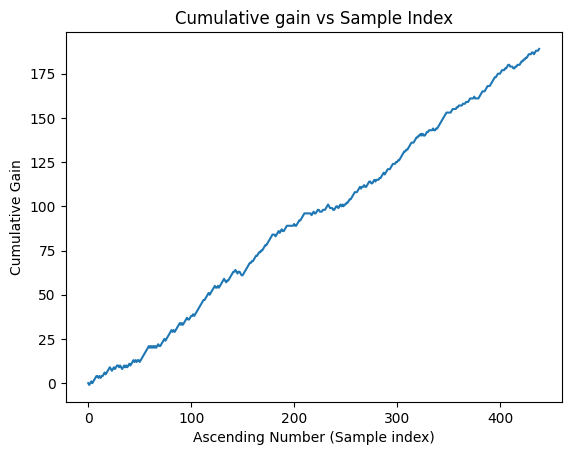

In [41]:
plt.plot(index_help, gain_cum)
plt.xlabel('Ascending Number (Sample index)')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative gain vs Sample Index')

In [42]:
# As accuracy, I will define how many time the agent won (so gain is 2), over how many times the agent played
unique, counts = np.unique(gain_total, return_counts=True)
print(f'The unique values are: {unique}')
print(f'The count values are:  {counts}')
print(f'Accuracy is counts[2]/sum(counts) * 100% = {counts[2]/sum(counts)*100:.2f}%')

The unique values are: [-1.  0.  1.]
The count values are:  [ 63 123 253]
Accuracy is counts[2]/sum(counts) * 100% = 57.63%


## Results for our model, when we apply all preprocessing steps in the test set:

* The unique values are: [-1.  0.  1.]
* The count values are:  [ 52  90 223]
* Accuracy is counts[2]/sum(counts) * 100% = 61.10%

These results are not encouraging, and from the cumulative gain plot, we understand that we do not have many fluctuations (generally an increasing trend), so accuracy should be a stable estimate for our test set.

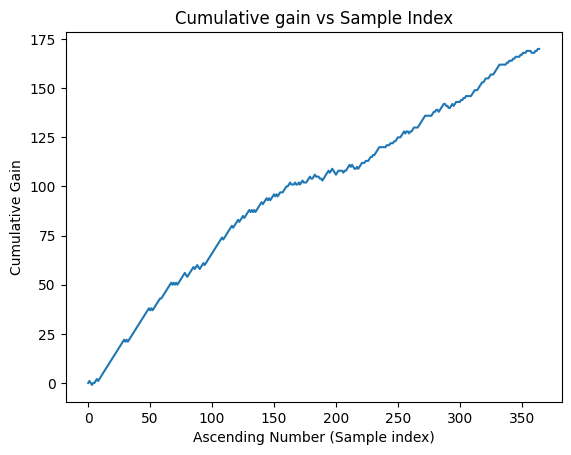

I tried also without the 4th pre-processing step (the image rotation), and the results are:
* The unique values are: [-1.  0.  1.]
* The count values are:  [ 35  36 294]
* Accuracy is counts[2]/sum(counts) * 100% = 80.55%
So, accuracy has increased, and we are getting there

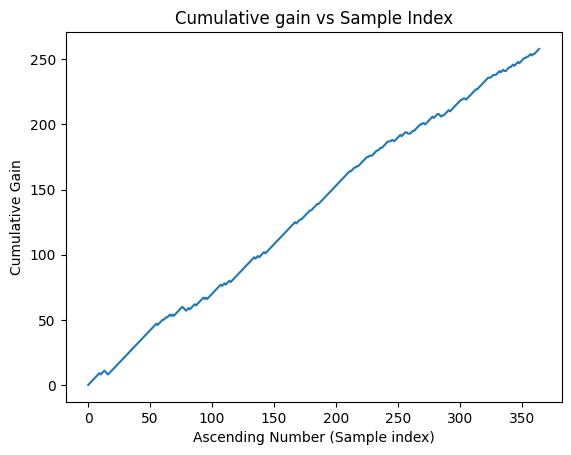

I tried, using only the add-noise pre-processing step, and these are the results:
* The unique values are: [-1.  1.]
* The count values are:  [ 11 354]
* Accuracy is counts[1]/sum(counts) * 100% = 96.99%

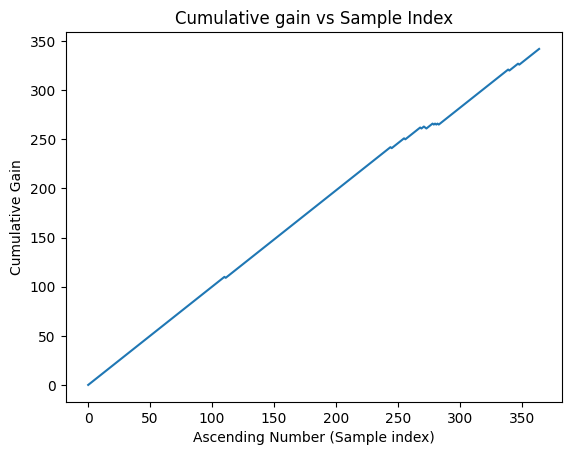

I also tried, without any pre-processing, and these are the results:
* The unique values are: [-1.  0.  1.]
* The count values are:  [  5   4 356]
* Accuracy is counts[2]/sum(counts) * 100% = 97.53%

We calculated the accuracy that CNN gave in the test set, so that's a good sign

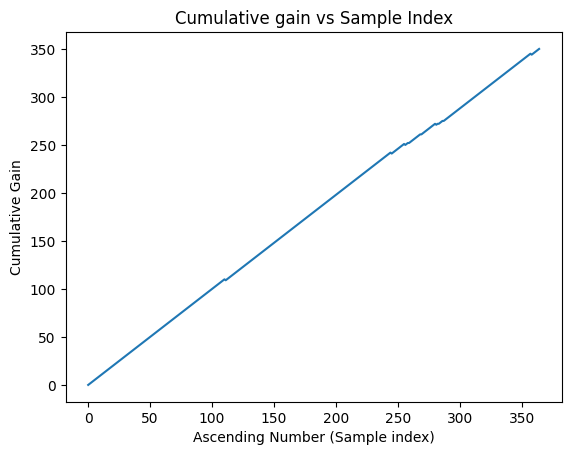

# 8. As end goal, try the accuracy of the agent (or model) on images outside of the dataset, e.g. from the internet or your own, which you must rescale to the same size. For example, you can try the action it will output for the attached image

I test with the dataset from https://www.kaggle.com/datasets/glushko/rock-paper-scissors-dataset, which shows both a human face and an action (rock, paper, scissors) in the picture, to see how my model would do.

In [43]:
dim1 = 20; dim2 = 30;

In [44]:
[images_rock_test, images_rock_labels_test] = return_all_images_grayscale('rock_test')
[images_scissors_test, images_scissors_labels_test] = return_all_images_grayscale('scissors_test')
[images_paper_test, images_paper_labels_test] = return_all_images_grayscale('paper_test')

In [45]:
# Create the x_test, y_test, by contatenating the respective arrays

x_test_test = np.concatenate((images_rock_test, images_scissors_test, images_paper_test))
y_test_test = np.concatenate((images_rock_labels_test, images_scissors_labels_test, images_paper_labels_test))

In [46]:
# We use the reshape method to do the flattening.
# We simply designate that the number of rows should remain the same, and -1 as second argument takes care of the other dimensions
x_test_test_flatten = x_test_test.reshape(x_test_test.shape[0],-1)
print(f'x_test.shape = {x_test_test.shape}. x_train_flatten.shape = {x_test_test_flatten.shape}')

x_test.shape = (540, 20, 30). x_train_flatten.shape = (540, 600)


In [47]:
# Normalize by dividing with 255
x_test_test_flatten_norm = x_test_test_flatten/255

In [48]:
# Convert y_train, y_test to one-hot encodings
num_classes = 3 # classes (0, 1, 2) -> (rock, scissors, paper)

y_test_test_tf = tf.one_hot(y_test_test, depth=num_classes)
y_test_test_tf.shape

TensorShape([540, 3])

In [49]:
# i will now try calculating the total gain for the whole test set
N = len(x_test_test)

gain_total_CNN = np.zeros(N)
gain_cum_CNN = np.zeros(N)
index_help_CNN = range(0,N)

for i in range(0, N):
  print(f'i = {i}')


  # get image from test set
  random_image = x_test_test[i]
  random_image_label = y_test_test[i]
  random_image_label_string = label_names[int(random_image_label)]

  # apply preprocessing to the image
  random_image = flip_vertically(random_image)
  random_image = flip_horizontally(random_image)
  random_image = add_noise(random_image)
  random_image = rotate_angle(random_image)

  # Convert image to tf array
  img_array = tf.keras.utils.img_to_array(random_image)
  img_array = tf.expand_dims(img_array, 0)

  # Calculate predictions
  predictions = cnn.predict(img_array)
  predicted_enemy_action = label_names[np.argmax(predictions[0])]

  gain_for_one_step = return_gain_step(predicted_enemy_action = predicted_enemy_action, actual_enemy_action = random_image_label_string)
  if i >=1:
    gain_cum_CNN[i] = gain_cum_CNN[i-1] + gain_for_one_step
  gain_total_CNN[i] = gain_for_one_step


i = 0
1/1 [==============================] - 0s 21ms/step
i = 1
1/1 [==============================] - 0s 23ms/step
i = 2
1/1 [==============================] - 0s 22ms/step
i = 3
1/1 [==============================] - 0s 22ms/step
i = 4
1/1 [==============================] - 0s 22ms/step
i = 5
1/1 [==============================] - 0s 22ms/step
i = 6
1/1 [==============================] - 0s 21ms/step
i = 7
1/1 [==============================] - 0s 24ms/step
i = 8
1/1 [==============================] - 0s 24ms/step
i = 9
1/1 [==============================] - 0s 22ms/step
i = 10
1/1 [==============================] - 0s 22ms/step
i = 11
1/1 [==============================] - 0s 22ms/step
i = 12
1/1 [==============================] - 0s 23ms/step
i = 13
1/1 [==============================] - 0s 21ms/step
i = 14
1/1 [==============================] - 0s 22ms/step
i = 15
1/1 [==============================] - 0s 21ms/step
i = 16
1/1 [==============================] - 0s 21ms/step
i = 17


Text(0.5, 1.0, 'Cumulative gain vs Sample Index')

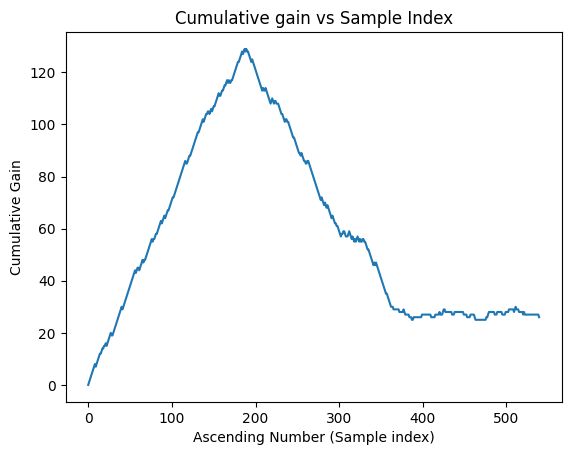

In [50]:
plt.plot(index_help_CNN, gain_cum_CNN)
plt.xlabel('Ascending Number (Sample index)')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative gain vs Sample Index')

In [51]:
# As accuracy, I will define how many time the agent won (so gain is 2), over how many times the agent played
unique, counts = np.unique(gain_total_CNN, return_counts=True)
print(f'The unique values are: {unique}')
print(f'The count values are:  {counts}')
print(f'Accuracy is counts[2]/sum(counts) * 100% = {counts[2]/sum(counts)*100:.2f}%')

The unique values are: [-1.  0.  1.]
The count values are:  [165 183 192]
Accuracy is counts[2]/sum(counts) * 100% = 35.56%


In [52]:
x_test_test_cnn = np.reshape(x_test_test_flatten_norm, (x_test_test_flatten_norm.shape[0], dim1,dim2,1))
print(x_test_test_cnn.shape)

cnn_test_loss, cnn_test_acc = cnn.evaluate(x_test_test_cnn, y_test_test_tf, verbose=2)
print('')
print(f'Our CNN has achieved a test accuracy of {cnn_test_acc*100:.2f}%')

(540, 20, 30, 1)
17/17 - 0s - loss: 3.5271 - accuracy: 0.3648 - 182ms/epoch - 11ms/step

Our CNN has achieved a test accuracy of 36.48%


The 2 ways of calculating accuracy did not give the same value, but they are close. If I do not add any pre-processing steps, these 2 values should be the same

## We notice that our model did not do as good, in these test data. Still, the images were harder than our train set. The train set was clear rock/paper/scissors images, with green background.

When doing all the pre-processing steps, we have:

* The unique values are: [-1.  0.  1.]
* The count values are:  [156 169 188]
* Accuracy is counts[2]/sum(counts) * 100% = 36.65%

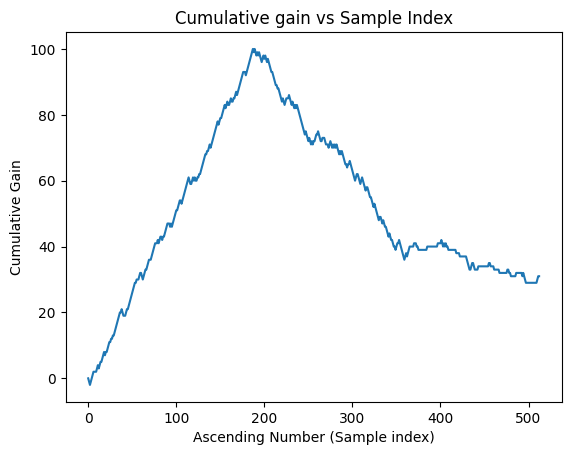

I tried without the 4th pre-processings step (the rotation), but the results did not seem to improve:
* The unique values are: [-1.  0.  1.]
* The count values are:  [163 169 181]
* Accuracy is counts[2]/sum(counts) * 100% = 35.28%

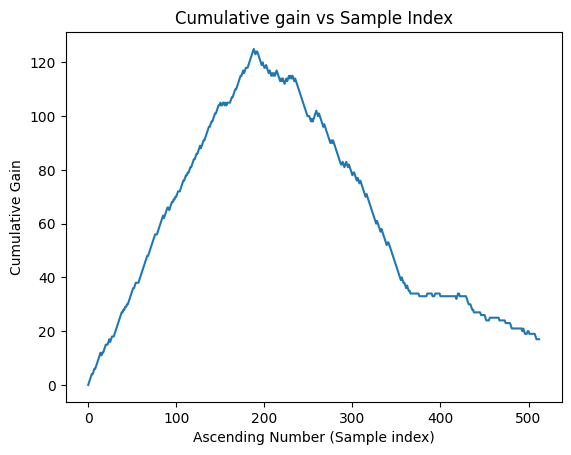

I tried while having kept only the add-noise pre-processings step, and these are the results:
* The unique values are: [-1.  0.  1.]
* The count values are:  [150 156 207]
* Accuracy is counts[2]/sum(counts) * 100% = 40.35%

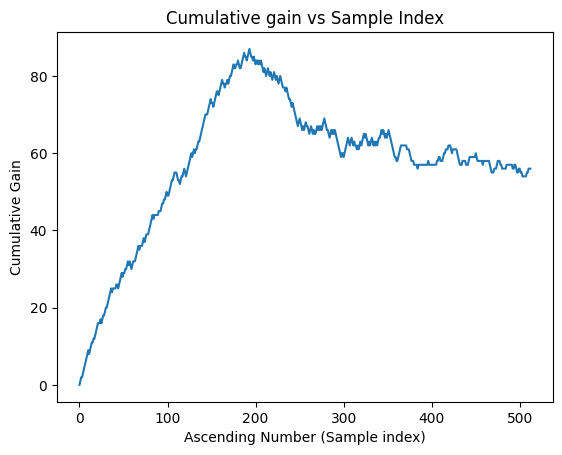

I also tried without any pre-processing, and these are the results:
* The unique values are: [-1.  0.  1.]
* The count values are:  [155 161 197]
* Accuracy is counts[2]/sum(counts) * 100% = 38.40%

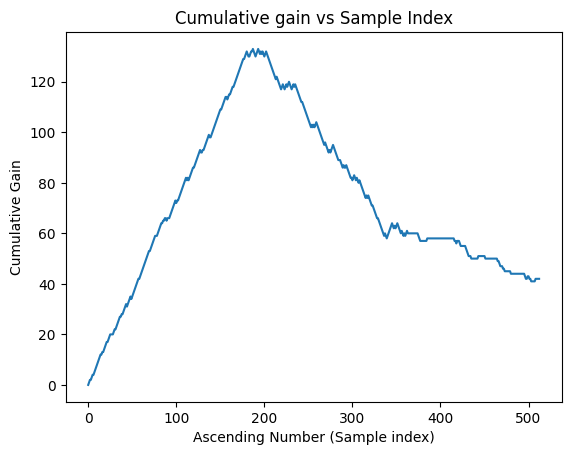

## Maybe the reason I am not getting good accuracy in the new test set, is because of image dimensions. Truly, I inspected the new images, and they are 300x300, so making them into 20x30 is distorting the images.
## Generally speaking, CNN are the go-to choice for image classification, and we achieved 97.52% accuracy with them. Still, I will also try some more sklearn methods, to see what accuracy they yield.

# Let's also try doing this with an SVM

In [53]:
from sklearn import svm
from sklearn.svm import LinearSVC

In [54]:
# I define our SVM model, then train it
model_SVM = svm.SVC()
#model_SVM = LinearSVC(dual="auto", random_state=0, tol=1e-5)
model_SVM.fit(x_train_flatten, y_train)

#
preds_SVM = model_SVM.predict(x_test_flatten)
acc_SVM = accuracy_score(preds_SVM, y_test)
print(f'SVM accuracy in the test set: {acc_SVM}')

SVM accuracy in the test set: 0.9316628701594533


In [55]:
# i will now try calculating the total gain for the whole test set
N = len(x_test)

gain_total_SVM = np.zeros(N)
gain_cum_SVM = np.zeros(N)
index_help = range(0,N)

for i in range(0, N):
 # print(f'i = {i}')


  # get image from test set
  random_image = x_test[i]
  random_image_label = y_test[i]
  random_image_label_string = label_names[int(random_image_label)]

  # apply preprocessing to the image
  random_image = flip_vertically(random_image)
  random_image = flip_horizontally(random_image)
  random_image = add_noise(random_image)
  random_image = rotate_angle(random_image)

  random_image_flatten = random_image.reshape(1, -1)

  # Calculate prediction
  prediction = model_SVM.predict(random_image_flatten)
  predicted_enemy_action = label_names[int(prediction[0])]

  gain_for_one_step = return_gain_step(predicted_enemy_action = predicted_enemy_action, actual_enemy_action = random_image_label_string)
  if i >=1:
    gain_cum_SVM[i] = gain_cum_SVM[i-1] + gain_for_one_step
  gain_total_SVM[i] = gain_for_one_step


Text(0.5, 1.0, 'Cumulative gain vs Sample Index')

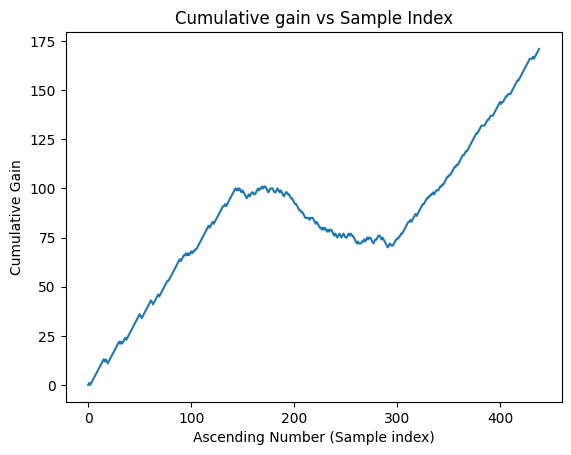

In [56]:
plt.plot(index_help, gain_cum_SVM)
plt.xlabel('Ascending Number (Sample index)')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative gain vs Sample Index')

In [57]:
# As accuracy, I will define how many time the agent won (so gain is 2), over how many times the agent played
unique, counts = np.unique(gain_total_SVM, return_counts=True)
print(f'The unique values are: {unique}')
print(f'The count values are:  {counts}')
print(f'Accuracy is counts[2]/sum(counts) * 100% = {counts[2]/sum(counts)*100:.2f}%')

The unique values are: [-1.  0.  1.]
The count values are:  [100  67 272]
Accuracy is counts[2]/sum(counts) * 100% = 61.96%


The results here, for all 4 pre-processing steps, are:
* The unique values are: [-1.  0.  1.]
* The count values are:  [ 62  65 238]
* Accuracy is counts[2]/sum(counts) * 100% = 65.21%

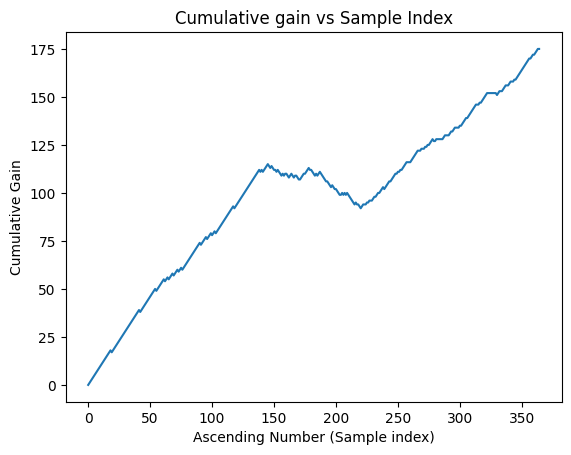

I tried without the 4th pre-processings step (the rotation), and these are the results:
* The unique values are: [-1.  0.  1.]
* The count values are:  [ 46  47 272]
* Accuracy is counts[2]/sum(counts) * 100% = 74.52%

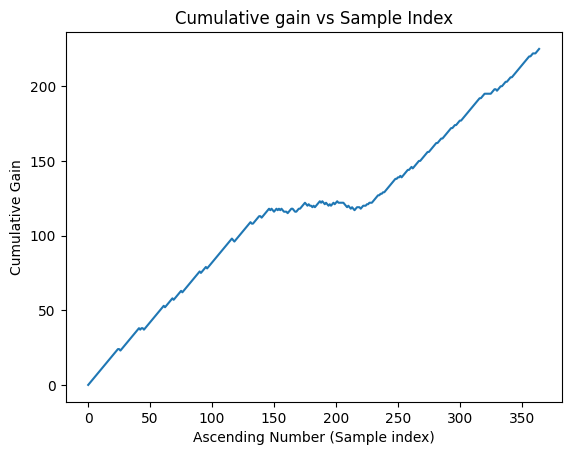

I tried while having kept only the add-noise pre-processings step, and these are the results:
* The unique values are: [-1.  0.  1.]
* The count values are:  [ 16  13 336]
* Accuracy is counts[2]/sum(counts) * 100% = 92.05%

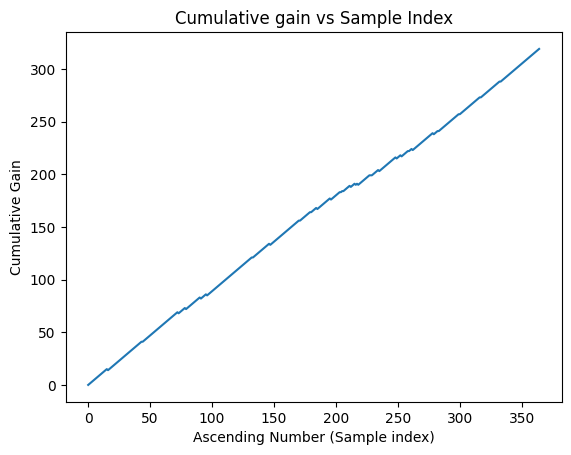

I also tried without any pre-processing, and these are the results:
* The unique values are: [-1.  0.  1.]
* The count values are:  [ 16  13 336]
* Accuracy is counts[2]/sum(counts) * 100% = 92.05%

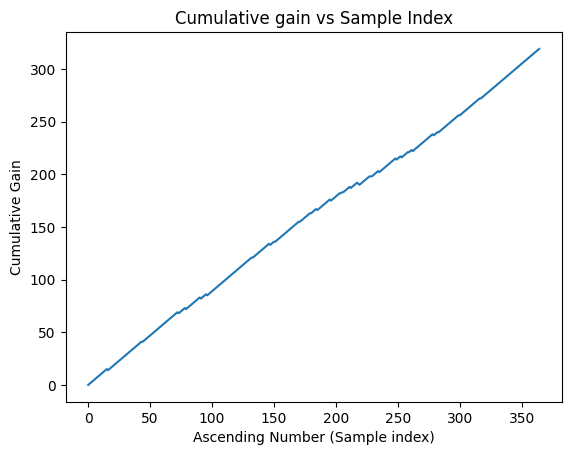

In [58]:
print(f'We found above accuracy of SVM = {acc_SVM}')
print(f'This agrees with the accuracy value that I found manually, when adding no pre-processing to the images')

We found above accuracy of SVM = 0.9316628701594533
This agrees with the accuracy value that I found manually, when adding no pre-processing to the images


## Let's also see how SVM will do in the external test set

In [59]:
# i will now try calculating the total gain for the whole test set
N = len(x_test_test)

gain_total_SVM = np.zeros(N)
gain_cum_SVM = np.zeros(N)
index_help = range(0,N)

for i in range(0, N):
 # print(f'i = {i}')


  # get image from test set
  random_image = x_test_test[i]
  random_image_label = y_test_test[i]
  random_image_label_string = label_names[int(random_image_label)]

  # apply preprocessing to the image
  random_image = flip_vertically(random_image)
  random_image = flip_horizontally(random_image)
  random_image = add_noise(random_image)
  random_image = rotate_angle(random_image)

  random_image_flatten = random_image.reshape(1, -1)

  # Calculate prediction
  prediction = model_SVM.predict(random_image_flatten)
  predicted_enemy_action = label_names[int(prediction[0])]

  gain_for_one_step = return_gain_step(predicted_enemy_action = predicted_enemy_action, actual_enemy_action = random_image_label_string)
  if i >=1:
    gain_cum_SVM[i] = gain_cum_SVM[i-1] + gain_for_one_step
  gain_total_SVM[i] = gain_for_one_step


Text(0.5, 1.0, 'Cumulative gain vs Sample Index')

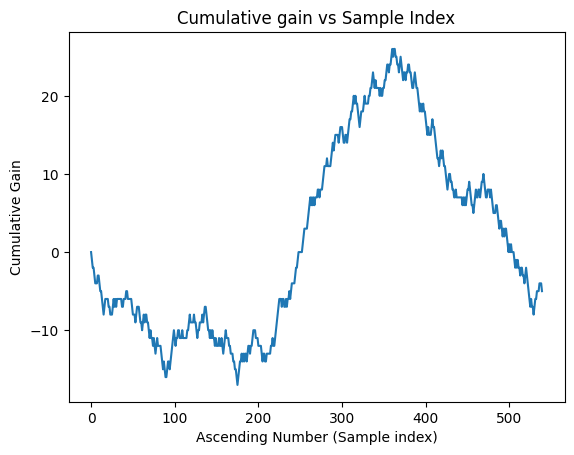

In [60]:
plt.plot(index_help, gain_cum_SVM)
plt.xlabel('Ascending Number (Sample index)')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative gain vs Sample Index')

In [61]:
# As accuracy, I will define how many time the agent won (so gain is 2), over how many times the agent played
unique, counts = np.unique(gain_total_SVM, return_counts=True)
print(f'The unique values are: {unique}')
print(f'The count values are:  {counts}')
print(f'Accuracy is counts[2]/sum(counts) * 100% = {counts[2]/sum(counts)*100:.2f}%')

The unique values are: [-1.  0.  1.]
The count values are:  [180 186 174]
Accuracy is counts[2]/sum(counts) * 100% = 32.22%


The results here, for all 4 pre-processing steps, are:
* The unique values are: [-1.  0.  1.]
* The count values are:  [163 196 181]
* Accuracy is counts[2]/sum(counts) * 100% = 33.52%

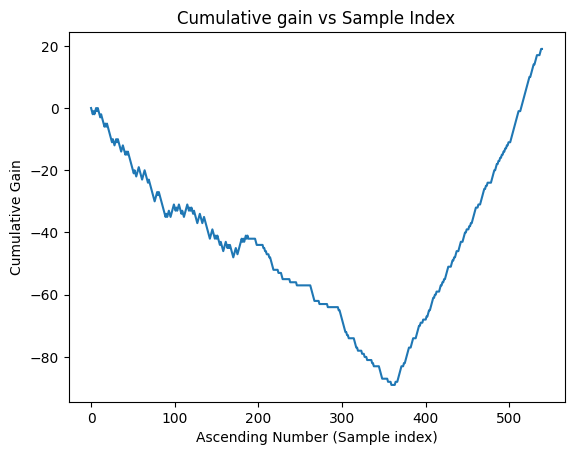

I tried without the 4th pre-processings step (the rotation):
* The unique values are: [-1.  0.  1.]
* The count values are:  [170 227 143]
* Accuracy is counts[2]/sum(counts) * 100% = 26.48%

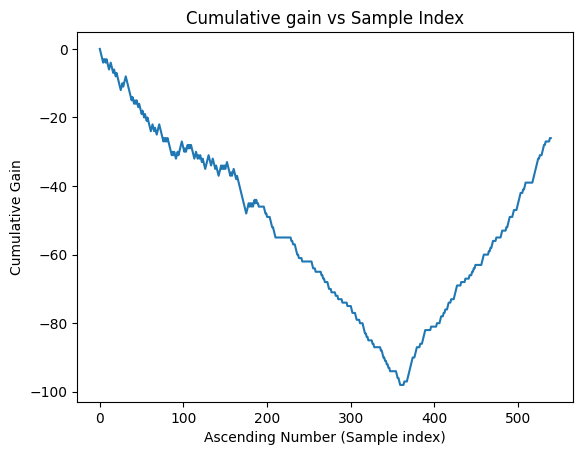

I tried while having kept only the add-noise pre-processings step, and these are the results:
* The unique values are: [-1.  0.  1.]
* The count values are:  [168 220 152]
* Accuracy is counts[2]/sum(counts) * 100% = 28.15%

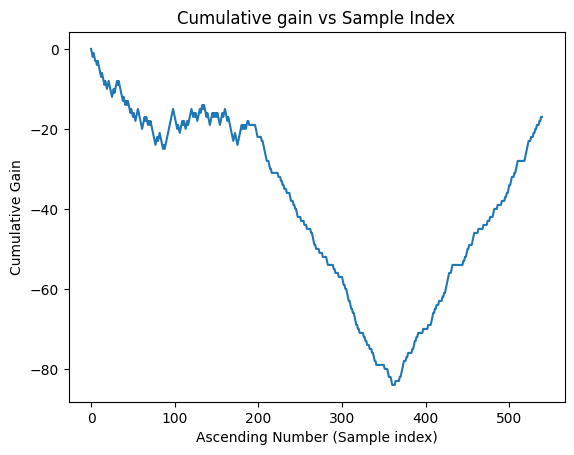

I also tried without any pre-processing, and these are the results:
* The unique values are: [-1.  0.  1.]
* The count values are:  [171 217 152]
* Accuracy is counts[2]/sum(counts) * 100% = 28.15%

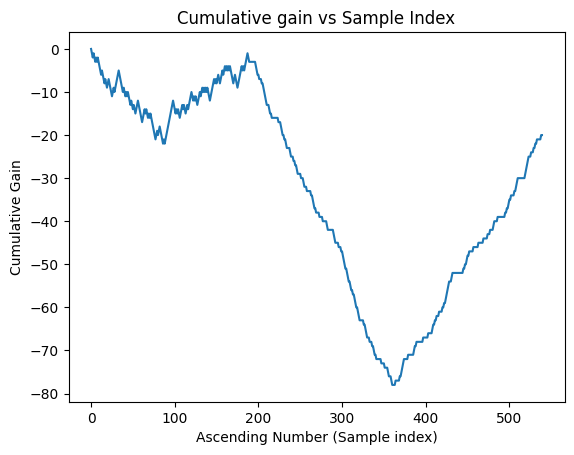

# **We notice how SVM had achieved 92% accuracy in the test set, but only accuracy in [28,33]% in the external test set.**
# **Our CNN achieved a maximum of 97.5% in the test set, and [35,40]% in the external test set.**

# Let's also try more sklearn models

In [62]:
from sklearn.neural_network import MLPClassifier

In [63]:
# I define our NN model, then train it
model_NN = MLPClassifier(random_state=0, max_iter=300)
model_NN.fit(x_train_flatten, y_train)

#
preds_NN = model_NN.predict(x_test_flatten)
acc_NN = accuracy_score(preds_NN, y_test)
print(f'NN accuracy in the test set: {acc_NN}')

NN accuracy in the test set: 0.7494305239179955


In [64]:
from sklearn.neighbors import NearestNeighbors

In [65]:
# I define our NN model, then train it
model_kNN = KNeighborsClassifier()
model_kNN.fit(x_train_flatten, y_train)

#

preds_kNN = model_kNN.predict(x_test_flatten)
acc_kNN = accuracy_score(preds_kNN, y_test)
print(f'kNN accuracy in the test set: {acc_kNN}')

kNN accuracy in the test set: 0.9066059225512528


In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
model_RF = RandomForestClassifier(max_depth=2, random_state=0)
model_RF.fit(x_train_flatten, y_train)

#

preds_RF = model_RF.predict(x_test_flatten)
acc_RF = accuracy_score(preds_RF, y_test)
print(f'RF accuracy in the test set: {acc_RF}')

RF accuracy in the test set: 0.7084282460136674


# **RESULTS In the internal test set:**
* Our CNN model achieved accuracy $\cong$ 97.52 %
* Some sklearn models that I tried (SVM, NN, kNN, RF) had accuracy:
  * 90.63 % (SVM)
  * 76.58 % (NN)
  * 89.53 % (kNN)
  * 69.69 % (RF).


# **RESULTS In the EXTERNAL test set:**
* Our CNN model achieved accuracy in the interval [35,40]%.
* In the interval [28,33]% (SVM)


# 3. In which images does our model work, and in which images does it not?

* I observed that the test accuracy after the initial training was quite high (97.5 %). Thus, our model did exceptionally good at classifying the initial images (clear rock/paper/scissors images, in monochrome green background).
* The test accuracy was not good in the test set of another dataset (https://www.kaggle.com/datasets/glushko/rock-paper-scissors-dataset). This dataset did not have clear rock/paper/scissors images, but also had faces and other objects in the images, and the background was not monochrome.
* I opted for using CNN, since I know that they perform well in image recognition, and that's why the test set accuracy was so high. Still, in the external test set, the accuracy was not good (the keras method gave 33%, and my manual method 57%)
* I notice how the other models that I tried had lower accuracy in the initial test set, so they would have even lower in the external test set.

# If we have time, we could also try doing it with reinforcement learning (with an agent)

# 5. Create an agent. Use summart to print the policy model. Describe the created Neural Network.

In [68]:
def import_agent():
  import gymnasium as gym
  import ray
  from ray.rllib.algorithms.ppo import PPOConfig
#import_agent()

In [69]:
def agent_definition_01():
  ray.shutdown()
  ray.init()

  config = PPOConfig()
  config.use_critic = True # Use Actor-Critic Architecture
  config.use_gae = True # Use Generalzed Advantage Updates
  config.lambda_ = 0.95 # Lambda Learning parameter
  config.user_kl_loss = True # Use KL-Penalty in addition to e-Clipping
  config.sgd_minibatch_size = 32 # Batch Size
  config.num_sgd_iter = 30 # Epochs
  config.shuffle_sequences = True # Whether to shffle episode sequences
  config.vf_loss_coeff = 0.5 # Value Function loss Regularization
  config.entropy_coeff = 0.001 # Entropy Regularization coefficient for Exploration
  config.clip_param = 0.2 # e-Clipping parameter

  agent = config.environment("LunarLander-v2").framework(framework='tf').build()
  agent.get_policy().model.base_model.summary(expand_nested=True)
#agent_definition_01()

# 6. Create a train loop to train the agent

In [70]:
def agent_train():
  train_iterations = 100
  average_rewards_per_iteration = []

  for i in range(train_iterations):
    log = agent.train()
    average_rewards = log['sampler_results']['episode_reward_mean']
    average_rewards_per_iteration.append(average_rewards)

    print(f'Iteration {i + 1}, Average Rewards: {average_rewards}')


  plt.plot(average_rewards_per_iteration)
  plt.title('PPO LunarLander-v2')
  plt.xlabel('Iterations')
  plt.ylabel('Average Rewards')
  plt.show()
#agent_train()

# 7. Use the library renderlab to "render" the gym environmonet in colab, to see how the trained agent plays.

In [71]:
#import renderlab as rl

In [72]:
def agent_run():
  env = gym.make("LunarLander-v2", render_mode = "rgb_array")
  env = rl.RenderFrame(env, "./output")

  observation, info = env.reset()

  while True:
    action = env.action_space.sample()
    observation,reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
      break

  env.play()
#agent_run()